<a href="https://colab.research.google.com/github/tabjun/image-data-study/blob/main/%EC%86%90%EA%B8%80%EC%94%A8_%EC%9D%B8%EC%8B%9D_%EB%AA%A8%EB%8D%B8_%EB%A7%8C%EB%93%A4%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 손글씨 인식 모델 만들기

## GPU 사용



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cuda


In [ ]:
from sklearn.datasets import load_digits

digits = load_digits()

x_data = digits['data']
y_data = digits['target']

print(x_data.shape)
print(y_data.shape)

(1797, 64)
(1797,)


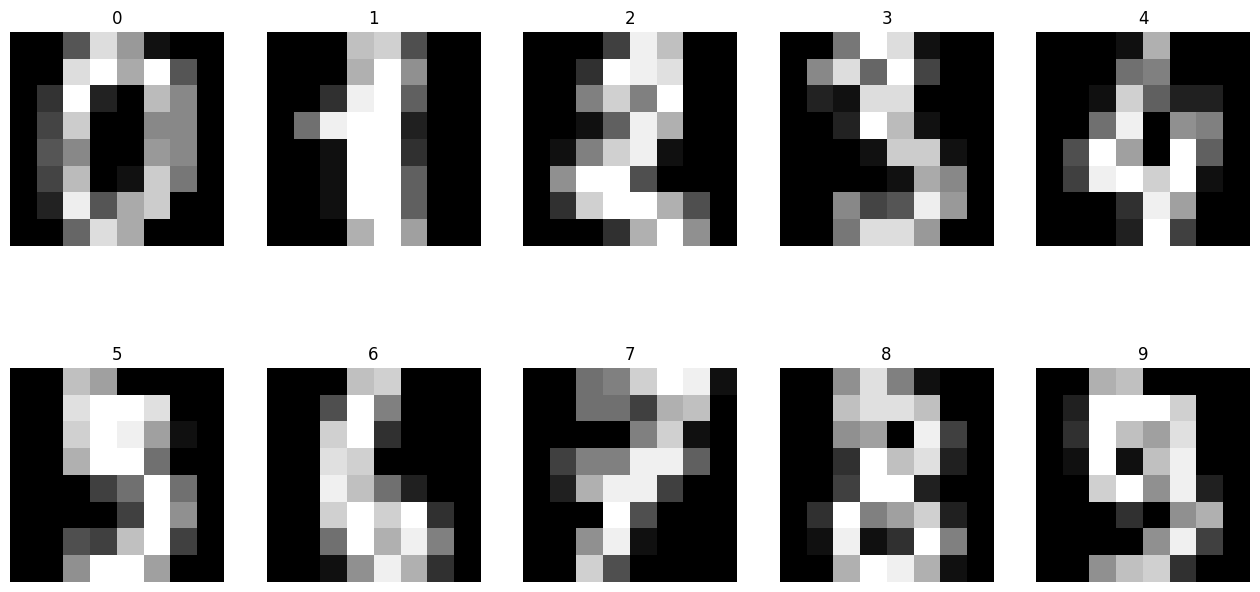

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16, 8))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(x_data[i].reshape((8, 8)), cmap='gray')
    ax.set_title(y_data[i])
    ax.axis('off')

## 파이토치 텐서로 변환

In [ ]:
x_data = torch.FloatTensor(x_data)
y_data = torch.LongTensor(y_data)

print(x_data.shape)
print(y_data.shape)

torch.Size([1797, 64])
torch.Size([1797])


## 원핫 인코딩

In [ ]:
y_one_hot = nn.functional.one_hot(y_data, num_classes=10).float()

y_one_hot[:10]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

## 데이터 분할

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_data, y_one_hot, test_size=0.2, random_state=2023)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

torch.Size([1437, 64]) torch.Size([1437, 10])
torch.Size([360, 64]) torch.Size([360, 10])


## 데이터 로더

데이터의 양이 많을때 배치 단위로 학습하는 방법

![](https://i.imgur.com/t83RUtL.png)

> https://www.baeldung.com/cs/epoch-vs-batch-vs-mini-batch

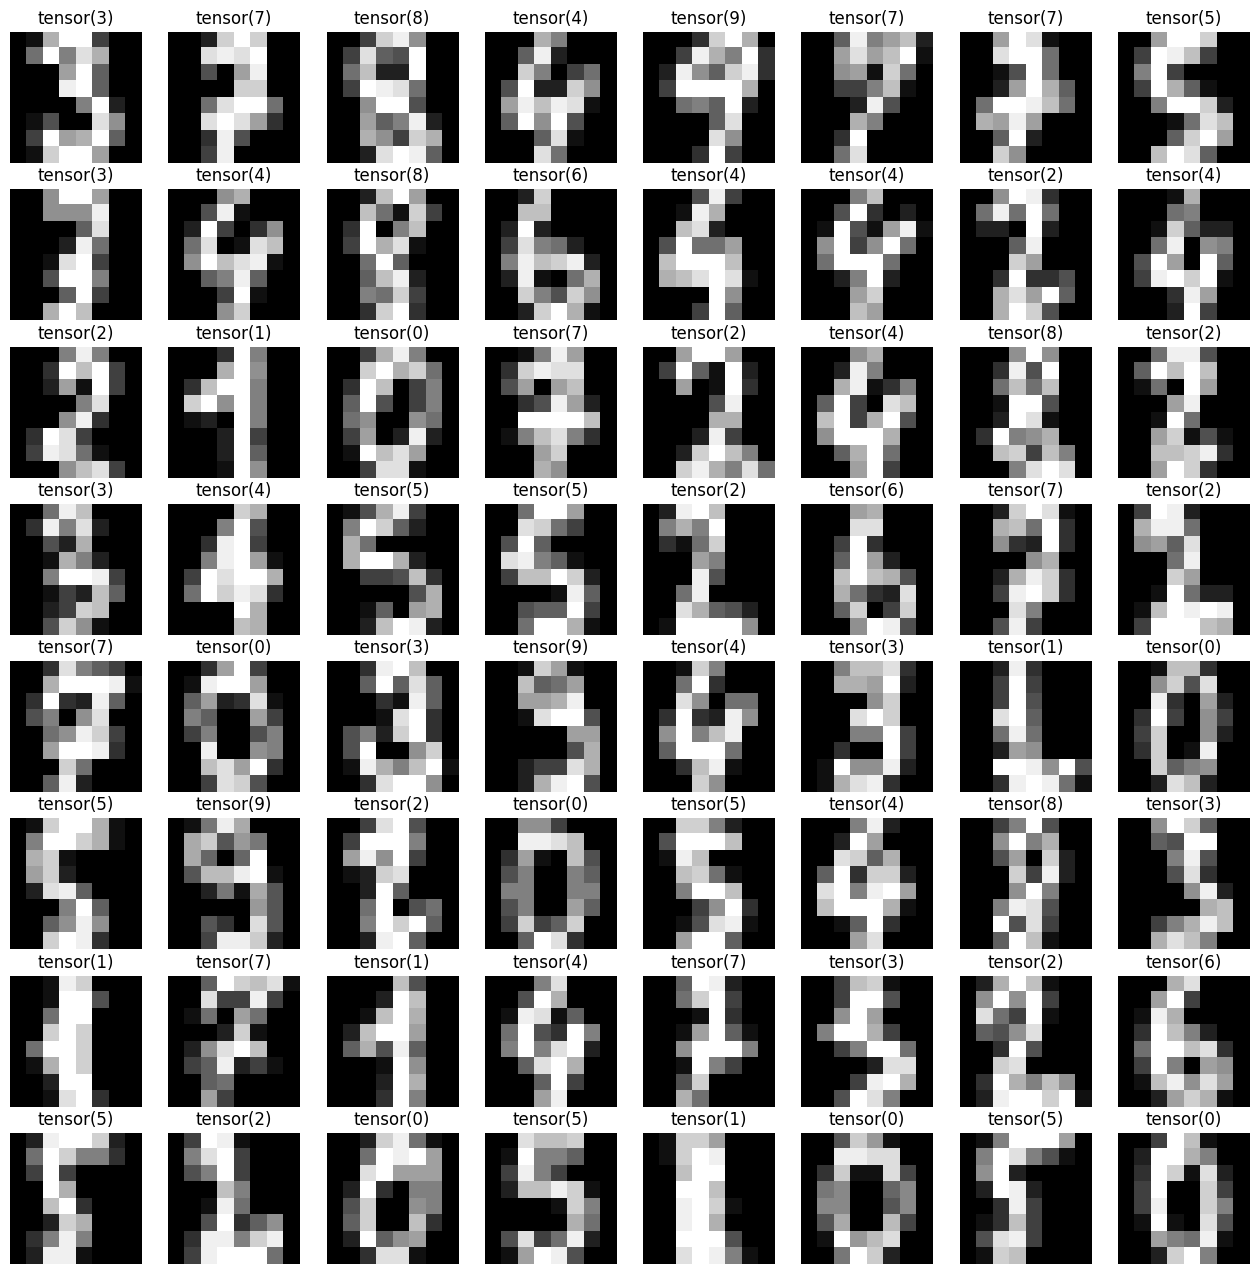

In [ ]:
loader = torch.utils.data.DataLoader(
    dataset=list(zip(x_train, y_train)),
    batch_size=64,
    shuffle=True)

imgs, labels = next(iter(loader))

fig, axes = plt.subplots(8, 8, figsize=(16, 16))

for ax, img, label in zip(axes.flatten(), imgs, labels):
    ax.imshow(img.reshape(8, 8), cmap='gray')
    ax.set_title(str(torch.argmax(label)))
    ax.axis('off')


## 모델 정의 및 훈련

In [ ]:
model = nn.Sequential(
    nn.Linear(64, 10),
)

optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 50

for epoch in range(epochs + 1):
    sum_losses = 0
    sum_accs = 0

    for x_batch, y_batch in loader: # 배치 단위(64개)로 데이터 로드/훈련
        # H(x) 계산
        y_pred = model(x_batch)

        # loss 계산
        loss = nn.CrossEntropyLoss()(y_pred, y_batch)

        # loss로 H(x) 개선하는 부분
        # gradient를 0으로 초기화
        optimizer.zero_grad()
        # 비용 함수를 미분하여 gradient(기울기) 계산
        loss.backward() # backward 연산
        # W와 b를 업데이트
        optimizer.step()

        # 배치 단위 loss 저장
        sum_losses = sum_losses + loss

        # 배치 단위 정확도 저장
        y_prob = nn.Softmax(1)(y_pred)
        y_pred_index = torch.argmax(y_prob, axis=1)
        y_batch_index = torch.argmax(y_batch, axis=1)
        acc = (y_batch_index == y_pred_index).float().sum() / len(y_batch) * 100

        sum_accs = sum_accs + acc

    avg_loss = sum_losses / len(loader)
    avg_acc = sum_accs / len(loader)

    print(f'Epoch {epoch:4d}/{epochs} Loss: {avg_loss:.6f} Accuracy: {avg_acc:.2f}%')

Epoch    0/50 Loss: 2.376335 Accuracy: 49.74%
Epoch    1/50 Loss: 0.393018 Accuracy: 88.02%
Epoch    2/50 Loss: 0.209312 Accuracy: 93.23%
Epoch    3/50 Loss: 0.163350 Accuracy: 95.31%
Epoch    4/50 Loss: 0.135342 Accuracy: 95.73%
Epoch    5/50 Loss: 0.112949 Accuracy: 96.52%
Epoch    6/50 Loss: 0.090721 Accuracy: 97.69%
Epoch    7/50 Loss: 0.074773 Accuracy: 98.08%
Epoch    8/50 Loss: 0.069157 Accuracy: 98.44%
Epoch    9/50 Loss: 0.066896 Accuracy: 98.51%
Epoch   10/50 Loss: 0.056424 Accuracy: 98.64%
Epoch   11/50 Loss: 0.055267 Accuracy: 98.63%
Epoch   12/50 Loss: 0.052981 Accuracy: 98.98%
Epoch   13/50 Loss: 0.053878 Accuracy: 98.98%
Epoch   14/50 Loss: 0.047744 Accuracy: 98.97%
Epoch   15/50 Loss: 0.053551 Accuracy: 98.97%
Epoch   16/50 Loss: 0.041308 Accuracy: 99.32%
Epoch   17/50 Loss: 0.035843 Accuracy: 99.73%
Epoch   18/50 Loss: 0.035391 Accuracy: 99.46%
Epoch   19/50 Loss: 0.034460 Accuracy: 99.37%
Epoch   20/50 Loss: 0.044950 Accuracy: 98.61%
Epoch   21/50 Loss: 0.043505 Accur

## 테스트

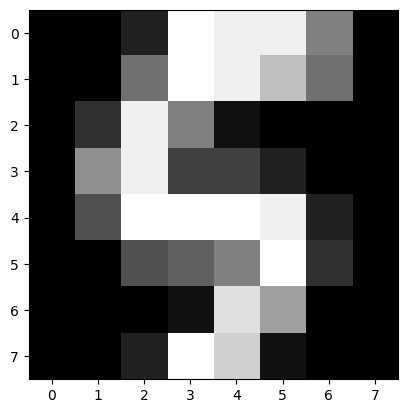

In [ ]:
plt.imshow(x_test[0].reshape((8, 8)), cmap='gray')

In [ ]:
y_pred = model(x_test)

y_pred[0]

tensor([ -0.0263,   0.6203, -19.4810,   1.2392,  -8.0286,  11.2914,   5.6595,
          0.1392,  -0.1213,  -2.0110], grad_fn=<SelectBackward0>)

In [ ]:
y_prob = nn.Softmax(1)(y_pred)

y_prob[0]

tensor([1.2111e-05, 2.3121e-05, 4.3064e-14, 4.2933e-05, 4.0535e-09, 9.9633e-01,
        3.5686e-03, 1.4292e-05, 1.1013e-05, 1.6644e-06],
       grad_fn=<SelectBackward0>)

In [ ]:
for i in range(10):
    print(f'숫자 {i}일 확률: {y_prob[0][i]:.2f}')

숫자 0일 확률: 0.00
숫자 1일 확률: 0.00
숫자 2일 확률: 0.00
숫자 3일 확률: 0.00
숫자 4일 확률: 0.00
숫자 5일 확률: 1.00
숫자 6일 확률: 0.00
숫자 7일 확률: 0.00
숫자 8일 확률: 0.00
숫자 9일 확률: 0.00


In [ ]:
y_pred_index = torch.argmax(y_prob, axis=1)
y_test_index = torch.argmax(y_test, axis=1)
accuracy = (y_test_index == y_pred_index).float().sum() / len(y_test) * 100

print(f'테스트 정확도는 {accuracy:.2f}% ')

테스트 정확도는 97.22% 입니다!
